# **Project: Brain Tumor Detector**

**Introduction**

A brain tumor is a collection, or mass, of abnormal cells in your brain. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening. 
脑瘤是大脑中异常细胞的集合或团块。脑瘤可能是癌性的（恶性的），也可能是非癌性的（良性的）。良性或恶性肿瘤生长时，会导致颅骨内压力增加。这可能会导致脑损伤，甚至危及生命。

The idea of this project is to try and build an AI-powered system to be able to not just detect brain tumor but also find out specific type of tumors by looking at Brain MRI Scans. This will be a multi-class classification problem to classify each brain MRI scan image into 1 out of 4 classes using deep learning models for CV. 
这个项目尝试构建一个人工智能系统，不仅能够检测脑瘤，还能通过查看脑部 MRI 扫描找出特定类型的肿瘤。这将是一个多类分类问题，使用 CV 深度学习模型将每个脑部 MRI 扫描图像分为 4 个类别中的 1 个。

**Dataset**

The dataset contains 7022 images of human brain MRI images which are classified into 4 classes: 
- glioma 神经胶质瘤 
- meningioma 脑膜瘤 
- no tumor 无肿瘤 
- and pituitary 垂体. 

The size of the images in this dataset is different and they need to be resized to 128x128 to make the models run faster. 

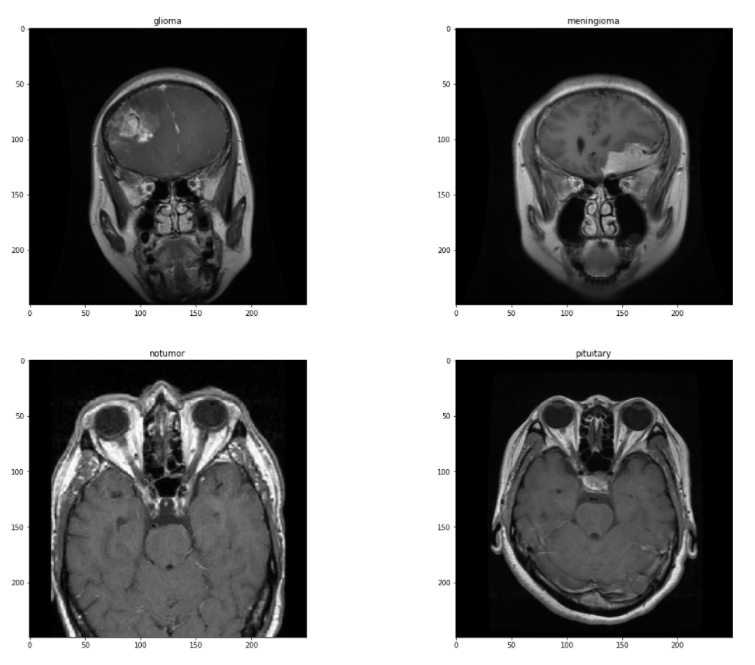

**Key Objective**

1. Baseline Model: 

    Start by building a simple Convolutional Neural Network (CNN) with 2-3 layers as a baseline, aiming for an accuracy around 90-91%.

2. Model Improvement with various techniques such as:

    - Data augmentation to increase the diversity of the training set.
    - More complex CNN architectures.
    - Pre-trained models and transfer learning.
    - Neural network training techniques like early stopping and dynamic learning rates.
    - The goal is to optimize the model and push its performance to 98-99% accuracy, as high accuracy is typically desired in healthcare applications.

3. Performance Evaluation: 

    Showcase the model's performance on the test dataset using tools like confusion matrices and classification reports.

In [ ]:
__author__ = "Bing Huang"
__email__ = "Binghuang1990@gmail.com"

## 0. Load Dependencies

In [1]:
#------------------------------------------
# For data manipulation, plotting, and etc.
#------------------------------------------
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm import tqdm    # Progress bar for loops

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import zipfile
import os

#------------------------------------------
# Import TensorFlow and Keras modules
#------------------------------------------
import tensorflow as tf
tf.random.set_seed(204)

# keras is a library for DL
# Import Keras (now part of TensorFlow)
from tensorflow.keras import datasets, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, ReLU, LeakyReLU, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Import TensorFlow-specific tools
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Pre-trained VGG16 model
from tensorflow.keras.applications import VGG16

#------------------------------------------
# Import Sklearn
#------------------------------------------
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder,LabelEncoder
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
print('TF Version:', tf.__version__)

TF Version: 2.10.0


In [3]:
!nvidia-smi

Thu Jan  9 22:48:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             12W /  200W |    1314MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled


## **1. Load Data**



In [7]:
zip_path = 'brain_tumor.zip'

# extract to
extracted_folder = 'brain_tumor_image'

# Extract the ZIP file
if not os.path.exists(extracted_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
    print(f'Extracted {zip_path} to {extracted_folder}')
else:
    print(f'The folder {extracted_folder} already exists.')

The folder brain_tumor_image already exists.


**Keras ImageDataGenerator** for loading images in batches when working with large datasets. This approach is crucial for handling massive amounts of data without overloading your computer's memory (RAM). 

https://keras.io/api/data_loading/image/

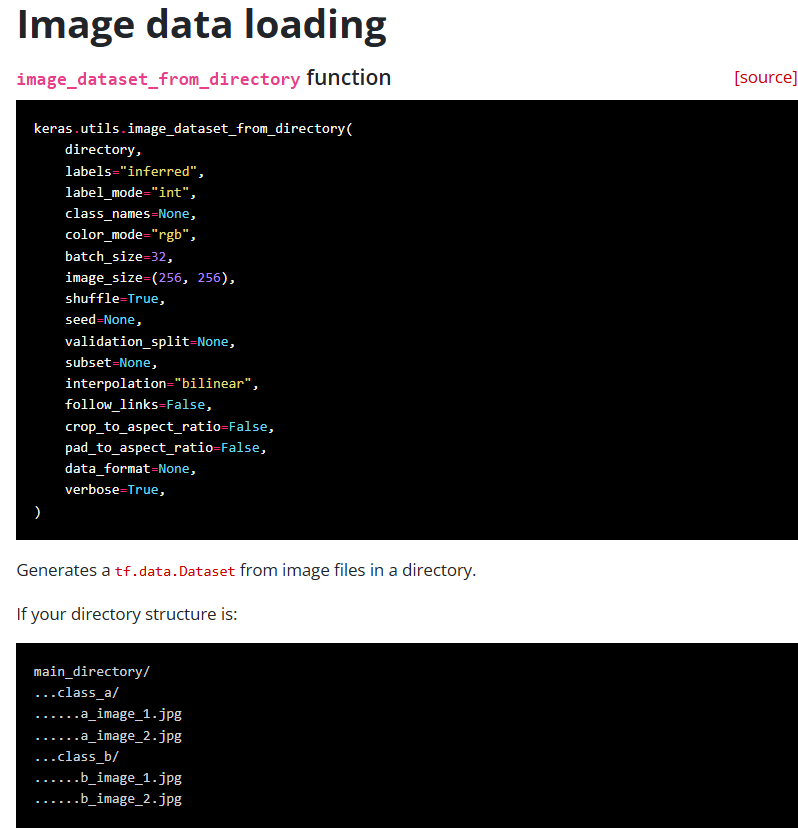

In [30]:
IMG_DIMS = (128, 128)              # Resize images to 128x128 for quicker training
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)        # RGB images

# Prepare training and validation datasets

### call this function before running any model to get data into train and validation splits
### data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./brain_tumor_image/Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./brain_tumor_image/Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds


In [31]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


#### 1.1 Explore the data

In [8]:
for img, labels in train_ds.take(1):    # The take(1) method retrieves the first batch of data (the first set of images and their corresponding labels).
  print(img.shape)
  print(labels.shape)
  break

# each batch consists of 32 images
# each image: 128x128 pixels and 3 color channels (RGB)
# each batch of 32 images (each time processes 32 images), so 32 corresponding labels

# because we predefined the variables


(32, 128, 128, 3)
(32,)


In [9]:
for img, labels in val_ds.take(1):    
  print(img.shape)
  print(labels.shape)
  break

(32, 128, 128, 3)
(32,)


In [10]:
# The number of batches in train/val data
print(f"Number of batches in training set: {len(train_ds)}")
print(f"Number of batches in validation set: {len(val_ds)}")

Number of batches in training set: 143
Number of batches in validation set: 36


#### 1.2 Image Data Visualization

In [36]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

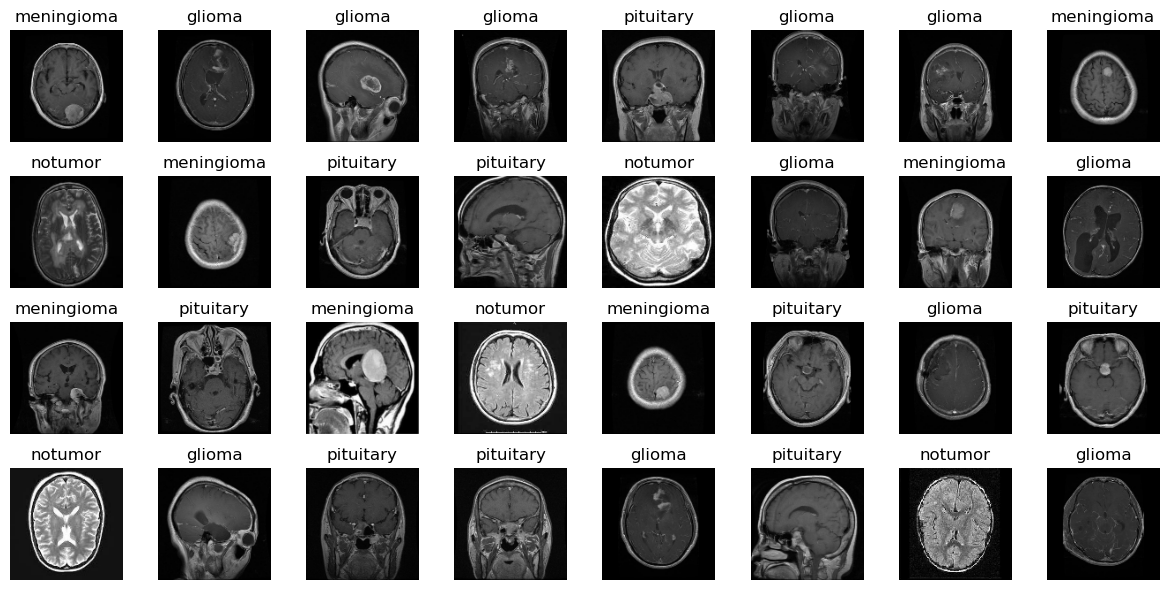

In [12]:
plt.figure(figsize = (12, 6))

for images, labels in train_ds.take(1):   # take(1): the first batch of data
    for i in range (32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

#### 1.3 Balanced Dataset? Distribution of four classes in the data set

Machine learning models trained on imbalanced datasets often become biased towards the majority class.

In [13]:
from collections import Counter

def get_class_distribution(dataset):
    # Collect labels from the dataset
    class_labels = []
    for _, labels in dataset:
        class_labels.extend(labels.numpy())  # Convert Tensor to NumPy array

    # Count occurrences of each class
    return Counter(class_labels)

# Load the datasets
train_ds, val_ds = prepare_train_and_val_datasets()

# Get class distributions
train_distribution = get_class_distribution(train_ds)
val_distribution = get_class_distribution(val_ds)

print("\n")

print("Training Dataset Distribution:")
for class_index, count in train_distribution.items():
    print(f"Class {classes[class_index]}: {count}")

print("\nValidation Dataset Distribution:")
for class_index, count in val_distribution.items():
    print(f"Class {classes[class_index]}: {count}")


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Training Dataset Distribution:
Class meningioma: 1090
Class notumor: 1247
Class glioma: 1077
Class pituitary: 1156

Validation Dataset Distribution:
Class meningioma: 249
Class glioma: 244
Class notumor: 348
Class pituitary: 301


Insights:

The distribution of classes in both the training and validation datasets indicates that the data is fairly balanced. Therefore, proceeding with this dataset without additional balancing techniques should yield reasonable performance.

Balancing techniques:

**Data-level**
- Oversampling: SMOTE Synthetic Minority Oversampling Technique
- Undersampling: Randomly remove samples from overrepresented classes, risk: remove valuable info leads to underfitting 

**Adjust the training process, rather than modifying data**
- class weighting: specify class_weight during model training-- higher weights for underrepresented classes

#### 1.4 Standardized RGB image data

Standardizing RGB channel values to the [0,1] range is a common preprocessing step for neural networks. It ensures that the input values are small, which helps in faster convergence during training and avoids numerical instability.

Note: Here, i just check the RGB values, rather than manually rescaling the pixel values

Because, rescalling the RGB values can be done in model building by including a **rescaling layer**, see the step 1 in creating the baseline model.

##### Check RGB values

In [14]:
def calculate_rgb_statistics(dataset):
    pixel_values = []
    
    for images, _ in dataset:
        pixel_values.append(images.numpy())  # Convert Tensor to NumPy
    
    pixel_values = np.concatenate(pixel_values, axis=0)  # Combine batches
    max = np.max(pixel_values, axis=(0, 1, 2))
    mean = np.mean(pixel_values, axis=(0, 1, 2))         # Mean across H, W, and all images
    std = np.std(pixel_values, axis=(0, 1, 2))           # Std across H, W, and all images
    
    return max, mean, std


In [15]:
max_train, mean_train, std_train = calculate_rgb_statistics(train_ds)
max_val, mean_val, std_val = calculate_rgb_statistics(val_ds)
print("Train Dataset RGB Mean and Std:", max_train, mean_train, std_train)
print("Validation Dataset RGB Mean and Std:", max_val, mean_val, std_val)

Train Dataset RGB Mean and Std: [255. 255. 255.] [35.93518  35.935963 35.94196 ] [45.52826  45.528996 45.532543]
Validation Dataset RGB Mean and Std: [255. 255. 255.] [46.431614 46.441723 46.455524] [50.903347 50.906395 50.91963 ]


#### 1.5 Class weights in training data

In [16]:
def calculate_class_weights(train_ds):
    # Extract class labels from the training dataset
    cls_train = []
    
    for _, labels in train_ds:
        cls_train.extend(labels.numpy())  # Convert labels to numpy and extend the list

    cls_train = np.array(cls_train)  # original class labels

    # Compute class weights
    class_weight = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(cls_train),
                                         y=cls_train)

    # Create a dictionary for class weights
    class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}

    return class_weight_dict

# Calculate class weights
class_weight_dict = calculate_class_weights(train_ds)
print(class_weight_dict)

{0: 1.0608170844939646, 1: 1.048165137614679, 2: 0.9161988773055333, 3: 0.9883217993079585}


## **2. CNN model_Baseline model**

#### 2.1 Build a CNN model with 3 layers

In [17]:
IMG_SHAPE

(128, 128, 3)

In [18]:
#-----------------
#create a CNN model
#------------------
model = Sequential()

#-----------------------------------------------------------------------------  
# 1. Rescaling layer to normalize the pixel values in image to [0,1] range
#-----------------------------------------------------------------------------
# recaling helps the model to converage faster during training  

model.add(Rescaling(1./255, input_shape=IMG_SHAPE)) 

#-------------------------------------
# 2. Add convolutional layers
#-------------------------------------
#  filter sizes (32 - 64 -128)
#  active function "ReLu" 
#  Maxpooling 2D: downsampling the spatial dimensions while preserving important info

#--- first layer ---
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_1' ))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_1'))
model.add(BatchNormalization())   #batch normalization layers after the convolutional layers for faster convergence and better regularization


#--- second layer ---
model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='Conv2D_2' ))
model.add(MaxPooling2D((2,2), strides=2, name ='Maxpool_2'))
model.add(BatchNormalization())

#--- third layer ---
model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='Conv2D_3' ))
model.add(MaxPooling2D((2,2), strides=2, name ='Maxpool_3'))
model.add(BatchNormalization())

#--------------------
# 3. Image classification
#------------------------
model.add(Flatten(name='Flatten'))

model.add(Dense(128, activation='relu',name = 'Dense_1'))
model.add(Dropout(0.2, name='Dropout_1'))                                      

model.add(Dense(128, activation='relu',name = 'Dense_2'))
model.add(Dropout(0.2, name='Dropout_2'))                                                                     

model.add(Dense(4, activation='softmax', name = 'Output'))   # 4 classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 Maxpool_1 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 Conv2D_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 Maxpool_2 (MaxPooling2D)    (None, 32, 32, 128)       0         
                                                        

#### 2.2 Compile the model

After building the CNN model, you need to compile it to configure the optimizer, loss function, and evaluation metrics. Compiling sets the framework for how the model will learn and be evaluated during training.

- Optimizer: adam, sgd
- 

In [20]:
optimizers_adam = Adam(learning_rate = 0.001)

model.compile(
    optimizer=optimizers_adam , 
    loss='sparse_categorical_crossentropy',  # Loss function
    metrics=['accuracy']  # Evaluation metric
)

#### 2.3 Train the model

**epoche: An epoch is one complete pass through the entire training dataset.**

- 4570 images
- batch_size = 32
- one epoche: 4570/32 = 143 batches

if youn tain for 10 epochs, the model will process 10 * 4570 images.

**Training for 10 epochs means the model will process the entire training dataset 10 times.**

The size of epochs?
- too many epochs: lead to overfitting --> where the model performs well on training data but poorly on new, unseen data.


In [21]:
epoches = 100
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (validation loss)
    patience=10,             # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

history = model.fit(
    train_ds,              # Training dataset
    validation_data=val_ds, # Validation dataset
    epochs=epoches,             # Number of epochs
    callbacks = early_stopping,
    verbose=1              # Display progress
)

Epoch 1/100
143/143 [==============================] - 8s 25ms/step - loss: 1.3922 - accuracy: 0.5989 - val_loss: 5.3984 - val_accuracy: 0.2636
Epoch 2/100
143/143 [==============================] - 3s 21ms/step - loss: 0.8310 - accuracy: 0.7013 - val_loss: 4.3513 - val_accuracy: 0.2811
Epoch 3/100
143/143 [==============================] - 3s 21ms/step - loss: 0.6666 - accuracy: 0.7449 - val_loss: 2.0085 - val_accuracy: 0.5201
Epoch 4/100
143/143 [==============================] - 3s 21ms/step - loss: 0.5741 - accuracy: 0.7934 - val_loss: 0.9736 - val_accuracy: 0.6909
Epoch 5/100
143/143 [==============================] - 3s 21ms/step - loss: 0.5778 - accuracy: 0.8020 - val_loss: 0.5316 - val_accuracy: 0.8292
Epoch 6/100
143/143 [==============================] - 3s 21ms/step - loss: 0.4089 - accuracy: 0.8460 - val_loss: 0.4504 - val_accuracy: 0.8468
Epoch 7/100
143/143 [==============================] - 3s 22ms/step - loss: 0.3500 - accuracy: 0.8665 - val_loss: 0.2998 - val_accuracy:

Plot the training and validation accuracy and loss over epochs

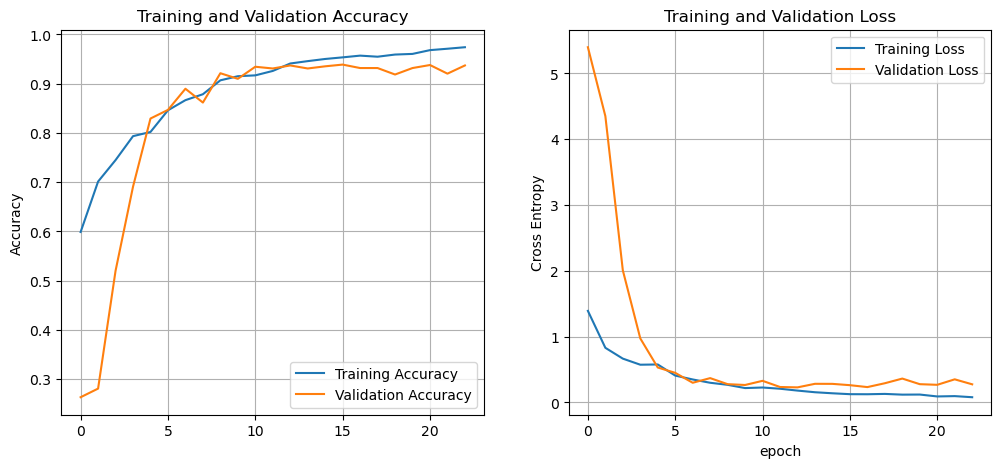

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

#### 2.4 Test Model Performance on the testing data

In [42]:
# load test data

random_seed = 24

def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./brain_tumor_image/Testing",             # Directory where the data is located
        class_names=classes,
        seed=random_seed,
        image_size=IMG_DIMS,     # will be resized for vgg16
        batch_size=32,
    )

    test_labels = []
    predictions = []

    #for imgs, labels in tqdm(test_ds.take(100),
                             #desc='Predicting on Test Data'):
    for imgs, labels in test_ds.take(100):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [49]:
y_true, predictions = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 5ms/step


##### Confusion Matrix

In [51]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[266  33   1   0]
 [ 14 235  53   4]
 [  0   1 404   0]
 [  1   6   2 291]]


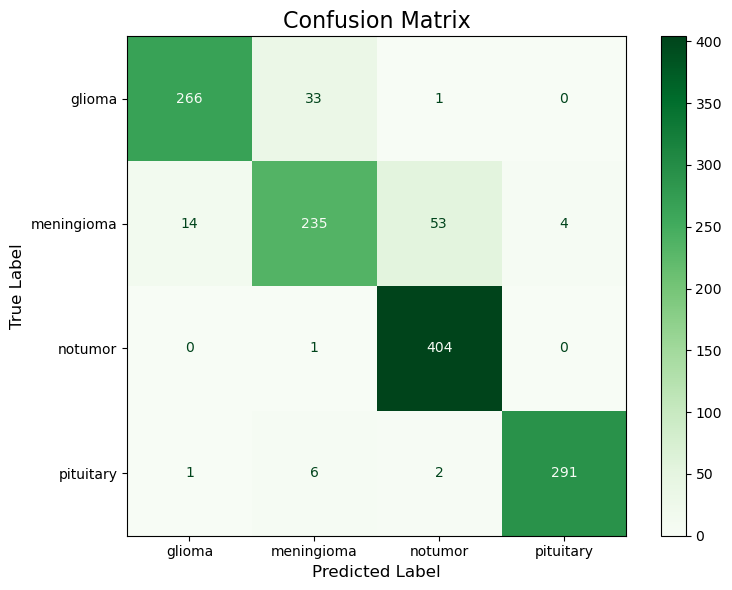

In [52]:
# Plot confusion matrix with better visuals

# Initialize confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Greens', ax=ax, values_format='d')  # Format values as integers
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)  # Disable grid for cleaner appearance
plt.tight_layout()

# Show the plot
plt.show()

##### Classification report

In [27]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      glioma     0.9466    0.8867    0.9157       300
  meningioma     0.8545    0.7680    0.8090       306
     notumor     0.8783    0.9975    0.9341       405
   pituitary     0.9864    0.9700    0.9782       300

    accuracy                         0.9123      1311
   macro avg     0.9165    0.9055    0.9092      1311
weighted avg     0.9131    0.9123    0.9108      1311



## 3. VGG16 CNN model

The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers, including 13 convolutional layers and 3 fully connected layers. 

In total, 16 weight layers and 3  additional layers like pooling and softmax.

VGG16 is a convolutional neural network model that’s used for **image recognition**. It’s unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It’s considered one of the best vision model architectures.

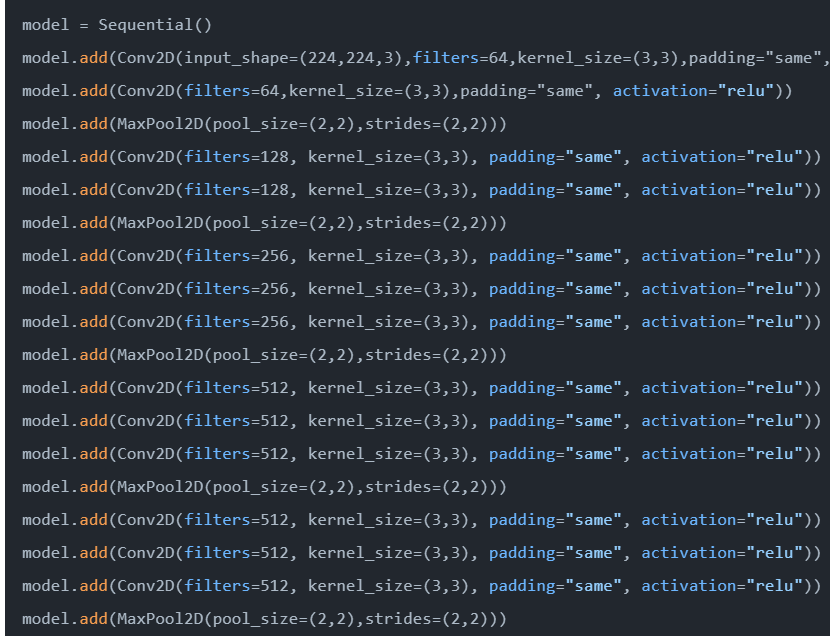


#### 3.1 Pre-trained VGG16 base model

- The VGG16 model from TensorFlow/Keras is designed to work with 224x224x3 images.

- This means you need to resize your images to 224x224 pixels and ensure they have 3 color channels (RGB) before feeding them to the model.

In [28]:
# Load pre-trained VGG16 model without top (no dense layers)
model_name = 'VGG16'

# Load VGG16 without fully connected layers (include_top=False)
VGG16_base = VGG16(weights='imagenet',
                  include_top=False,  
                  input_shape=(224, 224, 3))  

VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 3.2 Set the trainable layers in VGG16 model

In [29]:
# Check the type of layers in the pretrained model
print(type(VGG16_base.layers))
print(type(VGG16_base.layers[0]))
print(type(VGG16_base.layers[1]))
print(type(VGG16_base.layers[2]))

<class 'list'>
<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>


In [54]:
# check the layers' names
print(VGG16_base.layers[0].name)
print(VGG16_base.layers[1].name)
print(VGG16_base.layers[2].name)

input_3
block1_conv1
block1_conv2


In [55]:
len(VGG16_base.layers)

19

In [56]:
print(VGG16_base.layers[-5].name)
print(VGG16_base.layers[-4].name)
print(VGG16_base.layers[-3].name)
print(VGG16_base.layers[-2].name)
print(VGG16_base.layers[-1].name)

block5_conv2
block5_conv3
block5_pool


In [57]:
# only train the last three layers
# Freeze the first 16 layers
for layer in VGG16_base.layers[:16]:
    layer.trainable = False

# Train only the last 4
for layer in VGG16_base.layers[-4:]:
    layer.trainable = True

# check the summary
for layer in VGG16_base.layers:
  print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


#### 3.3 Resize images to (224, 224, 3)

Training and Validation datasets

In [32]:
IMG_DIMS = (224, 224)        
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)   

In [33]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [34]:
for img, labels in train_ds.take(1):    
  print(img.shape)
  print(labels.shape)
  break

(32, 224, 224, 3)
(32,)


#### 3.4 Build a CNN-VGG16 Model

In [ ]:
#-----------------
#create a CNN model
#------------------
model_vgg16 = Sequential()

#-----------------------------------------------------------------------------  
# 1. Rescaling layer to normalize the pixel values in image to [0,1] range
#-----------------------------------------------------------------------------
model_vgg16.add(Rescaling(1./255, input_shape=IMG_SHAPE)) 

#-------------------------------------
# 2. Add VGG base model
#-------------------------------------
model_vgg16.add(VGG16_base)

#--------------------
# 3. Image classification
#------------------------
model_vgg16.add(Flatten(name='Flatten'))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))   #  prevent overfitting                                    

model_vgg16.add(Dense(4, activation='softmax', name = 'Output'))  

model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 21,138,500


#### 3.5 Compile VGG16 model

In [38]:
opt_rmsprop = RMSprop(learning_rate=1e-5) 

model_vgg16.compile(optimizer=opt_rmsprop,
              loss='SparseCategoricalCrossentropy',      
              metrics=['accuracy'])

#### 3.6 Train VGG16 Model

In [ ]:
epochs = 50

earlystop = EarlyStopping(monitor='val_accuracy', patience = 5, mode='max', restore_best_weights=True)

history = model_vgg16.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    class_weight={0:5.0, 1:1.0, 2:0.6, 3:0.8},
                    callbacks = [earlystop]
                   )

Epoch 1/50
143/143 [==============================] - 49s 278ms/step - loss: 0.8673 - accuracy: 0.6965 - val_loss: 0.3117 - val_accuracy: 0.8940
Epoch 2/50
143/143 [==============================] - 31s 219ms/step - loss: 0.4612 - accuracy: 0.8497 - val_loss: 0.3569 - val_accuracy: 0.8616
Epoch 3/50
143/143 [==============================] - 31s 220ms/step - loss: 0.2933 - accuracy: 0.9026 - val_loss: 0.1920 - val_accuracy: 0.9264
Epoch 4/50
143/143 [==============================] - 32s 221ms/step - loss: 0.2309 - accuracy: 0.9304 - val_loss: 0.1798 - val_accuracy: 0.9299
Epoch 5/50
143/143 [==============================] - 31s 220ms/step - loss: 0.1627 - accuracy: 0.9499 - val_loss: 0.1222 - val_accuracy: 0.9553
Epoch 6/50
143/143 [==============================] - 31s 219ms/step - loss: 0.1246 - accuracy: 0.9621 - val_loss: 0.1380 - val_accuracy: 0.9536
Epoch 7/50
143/143 [==============================] - 31s 219ms/step - loss: 0.0927 - accuracy: 0.9737 - val_loss: 0.1025 - val_ac

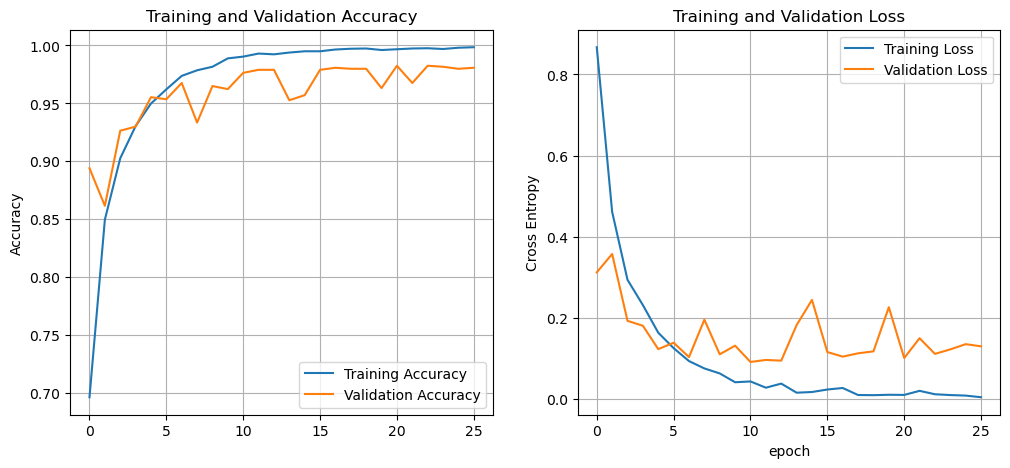

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

#### 3.7 Test Model performance

In [44]:
y_true, predictions = eval_model_on_test(model_vgg16)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step


##### Confusion Matrix

In [45]:
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[292   8   0   0]
 [  2 297   4   3]
 [  1   2 402   0]
 [  0   0   0 300]]


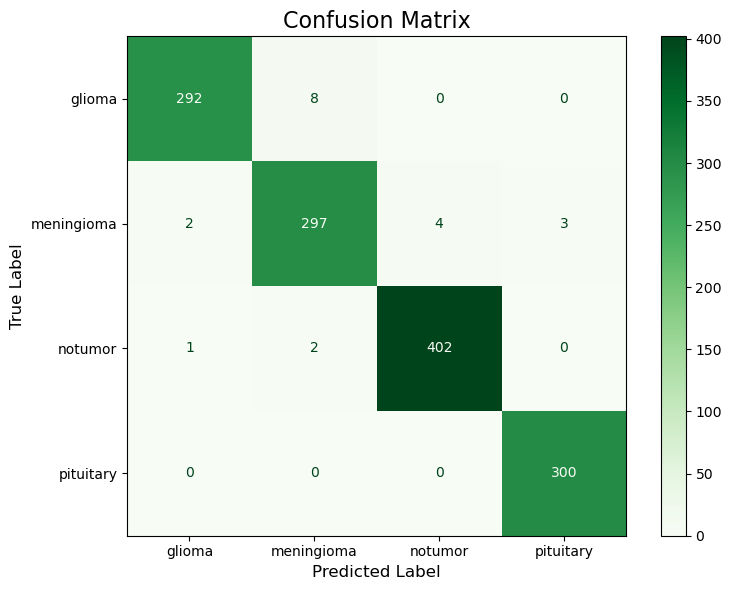

In [46]:
# Initialize confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Greens', ax=ax, values_format='d')  # Format values as integers
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)  # Disable grid for cleaner appearance
plt.tight_layout()

# Show the plot
plt.show()

##### Classification report

In [47]:
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      glioma     0.9898    0.9733    0.9815       300
  meningioma     0.9674    0.9706    0.9690       306
     notumor     0.9901    0.9926    0.9914       405
   pituitary     0.9901    1.0000    0.9950       300

    accuracy                         0.9847      1311
   macro avg     0.9844    0.9841    0.9842      1311
weighted avg     0.9848    0.9847    0.9847      1311

